**Problem Statement**

The aim is to compare the performance of different neural networks on different datasets. Here the datasets considered are MNIST, FMNIST and CIFAR-10. The chosen convolutional neural networks are LeNet-5, AlexNet, GoogLeNet, VGGNet, ResNet, Xception, and SENet. The comparison is done based on the metrics such as loss curves, accuracy, precision, recall and F1-score.

In [ ]:
!pip install torch torchvision

In [ ]:
# Load MNIST, FashionMNIST, CIFAR-10
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the MNIST dataset
])

# Downloading the MNIST dataset
train_dataset_mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=128, shuffle=False)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3110967.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 462244.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3871455.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8596809.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_fmnist = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_fmnist = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader_fmnist = DataLoader(dataset=train_dataset_fmnist, batch_size=128, shuffle=True)
test_loader_fmnist = DataLoader(dataset=test_dataset_fmnist, batch_size=128, shuffle=False)


100%|██████████| 26421880/26421880 [00:07<00:00, 3418952.52it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208339.80it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3946499.53it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6014561.84it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset_cifar10 = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset_cifar10 = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader_cifar10 = DataLoader(dataset=train_dataset_cifar10, batch_size=128, shuffle=True)
test_loader_cifar10 = DataLoader(dataset=test_dataset_cifar10, batch_size=128, shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 34595926.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Defining the train and test functions to train and test the neural networks
import numpy as np
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def CNN_par(net,lr=0.001):
  optimizer = optim.Adam(net.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
  return optimizer,criterion,scheduler

def train(epochs, net, train_loader, optimizer, criterion, scheduler):
    net.train()
    loss_history = []

    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} completed. Loss: {loss.item():.4f}")

    plt.plot(loss_history)
    plt.title("Training Loss")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.show()

# For testing MNIST data
def evaluate(net, test_loader, criterion):
    net.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.view_as(pred).cpu().numpy())
            all_outputs.extend(output.cpu().numpy())

    # Calculate metrics
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

    # Classification report and F1-Score
    if test_loader==test_loader_mnist:
      all_preds = np.argmax(all_outputs, axis=1)
      print(classification_report(all_targets, all_preds))
      print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))
    elif test_loader==test_loader_fmnist:
      all_preds = np.argmax(all_outputs, axis=1)
      labels=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
      print(classification_report(all_targets, all_preds, target_names=labels))
      print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))
    else:
      all_preds = np.argmax(all_outputs, axis=1)
      labels=[
        'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
        'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
      print(classification_report(all_targets, all_preds, target_names=labels))
      print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))
    # ROC Curve for each class
    targets_one_hot = label_binarize(all_targets, classes=np.arange(10))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], np.array(all_outputs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(10):
      if test_loader==test_loader_mnist:
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for digit {i}')
      else:
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if test_loader==test_loader_mnist:
      plt.title('Receiver Operating Characteristic for each digit')
    elif test_loader==test_loader_fmnist:
      plt.title('Receiver Operating Characteristic for each FMNIST class')
    else:
       plt.title('Receiver Operating Characteristic for each CIFAR-10 class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Defining LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet5().to(device)


Epoch 1/15 completed. Loss: 0.1689
Epoch 2/15 completed. Loss: 0.0338
Epoch 3/15 completed. Loss: 0.0612
Epoch 4/15 completed. Loss: 0.0326
Epoch 5/15 completed. Loss: 0.0137
Epoch 6/15 completed. Loss: 0.0362
Epoch 7/15 completed. Loss: 0.0125
Epoch 8/15 completed. Loss: 0.0090
Epoch 9/15 completed. Loss: 0.0086
Epoch 10/15 completed. Loss: 0.0105
Epoch 11/15 completed. Loss: 0.0029
Epoch 12/15 completed. Loss: 0.0019
Epoch 13/15 completed. Loss: 0.0006
Epoch 14/15 completed. Loss: 0.0016
Epoch 15/15 completed. Loss: 0.0085


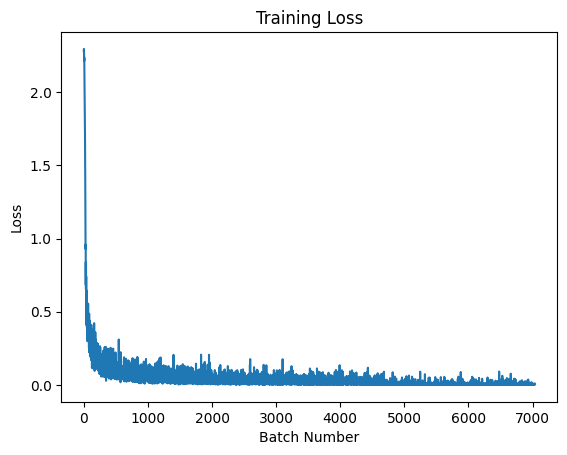

In [ ]:
# Training MNIST on LeNet-5
optimizer,criterion,scheduler = CNN_par(lenet)
train(15, lenet, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0002, Accuracy: 9928/10000 (99%)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

F1 Score: 0.9926846249834114


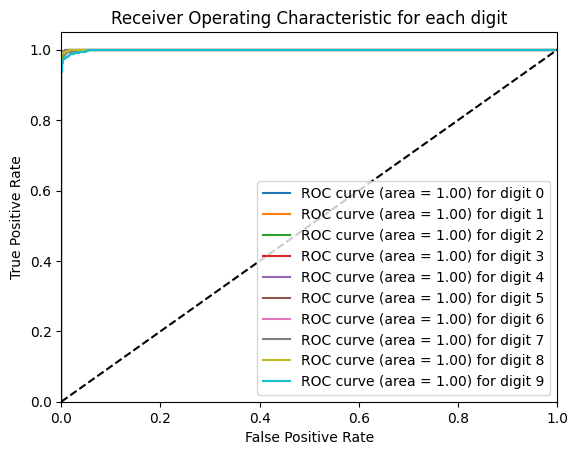

In [ ]:
# Testing MNIST on LeNet-5
evaluate(lenet, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.1353
Epoch 2/20 completed. Loss: 0.2074
Epoch 3/20 completed. Loss: 0.2003
Epoch 4/20 completed. Loss: 0.1415
Epoch 5/20 completed. Loss: 0.2312
Epoch 6/20 completed. Loss: 0.1847
Epoch 7/20 completed. Loss: 0.0900
Epoch 8/20 completed. Loss: 0.2103
Epoch 9/20 completed. Loss: 0.1165
Epoch 10/20 completed. Loss: 0.1269
Epoch 11/20 completed. Loss: 0.2524
Epoch 12/20 completed. Loss: 0.1301
Epoch 13/20 completed. Loss: 0.1371
Epoch 14/20 completed. Loss: 0.2835
Epoch 15/20 completed. Loss: 0.0973
Epoch 16/20 completed. Loss: 0.1108
Epoch 17/20 completed. Loss: 0.1718
Epoch 18/20 completed. Loss: 0.1284
Epoch 19/20 completed. Loss: 0.1809
Epoch 20/20 completed. Loss: 0.1008


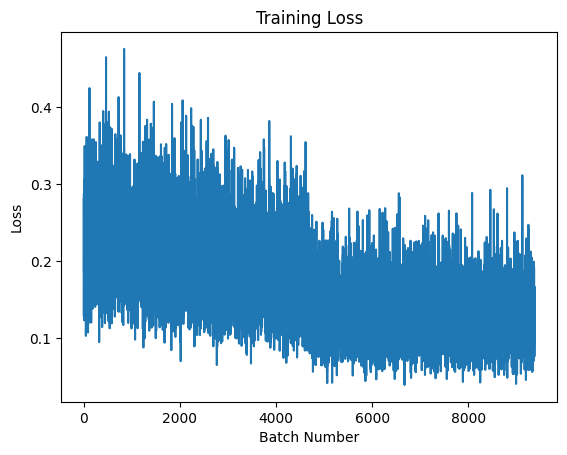

In [ ]:
# Training FMNIST on LeNet-5
optimizer,criterion,scheduler = CNN_par(lenet)
train(20, lenet, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0023, Accuracy: 9074/10000 (91%)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.84      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.85      0.86      1000
       Dress       0.89      0.92      0.90      1000
        Coat       0.85      0.86      0.86      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.75      0.74      0.74      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

F1 Score: 0.9072602849781852


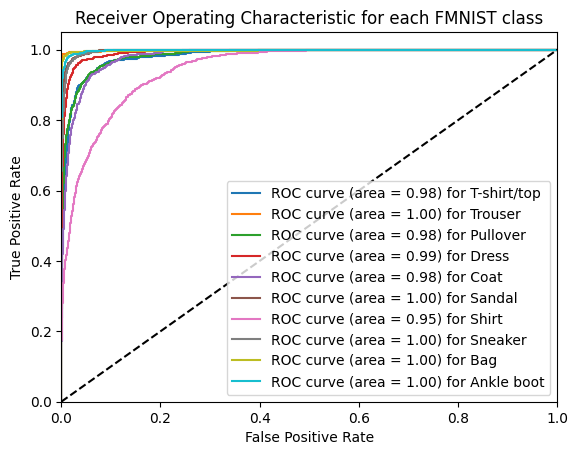

In [ ]:
# Testing FMNIST on LeNet-5
evaluate(lenet, test_loader_fmnist, criterion)

In [ ]:
# As the CIFAR-10 dataset contains RGB, we have 3 input channels. So, we modify the CNN
class LeNet_C(nn.Module):
    def __init__(self):
        super(LeNet_C, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = torch.relu(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
lenet_cif = LeNet_C().to(device)

Epoch 1/20 completed. Loss: 1.3465
Epoch 2/20 completed. Loss: 1.4467
Epoch 3/20 completed. Loss: 1.1012
Epoch 4/20 completed. Loss: 1.1823
Epoch 5/20 completed. Loss: 0.9332
Epoch 6/20 completed. Loss: 0.8397
Epoch 7/20 completed. Loss: 0.9068
Epoch 8/20 completed. Loss: 1.0808
Epoch 9/20 completed. Loss: 1.0805
Epoch 10/20 completed. Loss: 0.7909
Epoch 11/20 completed. Loss: 0.6624
Epoch 12/20 completed. Loss: 1.0341
Epoch 13/20 completed. Loss: 0.7313
Epoch 14/20 completed. Loss: 0.6816
Epoch 15/20 completed. Loss: 0.7574
Epoch 16/20 completed. Loss: 0.6911
Epoch 17/20 completed. Loss: 0.7432
Epoch 18/20 completed. Loss: 0.8641
Epoch 19/20 completed. Loss: 0.6151
Epoch 20/20 completed. Loss: 0.7127


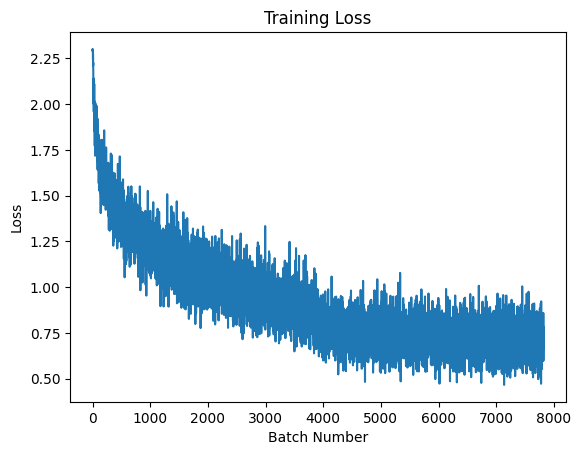

In [ ]:
# Training CIFAR-10 on LeNet-5
optimizer,criterion,scheduler = CNN_par(lenet_cif)
train(20, lenet_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0080, Accuracy: 6620/10000 (66%)

              precision    recall  f1-score   support

    Airplane       0.71      0.71      0.71      1000
  Automobile       0.79      0.77      0.78      1000
        Bird       0.59      0.48      0.53      1000
         Cat       0.49      0.46      0.48      1000
        Deer       0.58      0.61      0.60      1000
         Dog       0.55      0.59      0.57      1000
        Frog       0.71      0.76      0.73      1000
       Horse       0.71      0.70      0.70      1000
        Ship       0.77      0.79      0.78      1000
       Truck       0.71      0.75      0.73      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

F1 Score: 0.6604654975961772


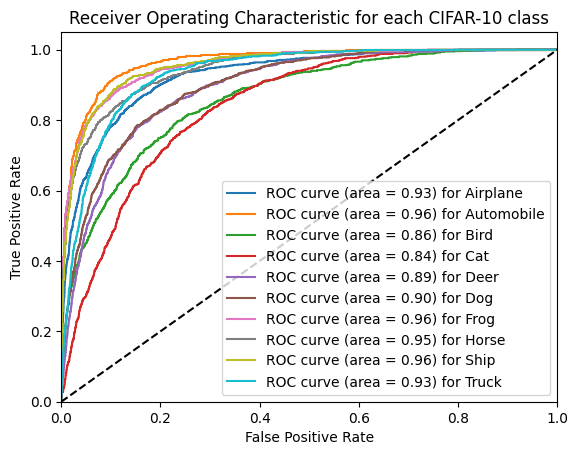

In [ ]:
# Testing CIFAR-10 on LeNet-5
evaluate(lenet_cif, test_loader_cifar10, criterion)

In [ ]:
# Defining AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return x
alexnet = AlexNet().to(device)


Epoch 1/15 completed. Loss: 0.1041
Epoch 2/15 completed. Loss: 0.1135
Epoch 3/15 completed. Loss: 0.1548
Epoch 4/15 completed. Loss: 0.0012
Epoch 5/15 completed. Loss: 0.1261
Epoch 6/15 completed. Loss: 0.0104
Epoch 7/15 completed. Loss: 0.0554
Epoch 8/15 completed. Loss: 0.0135
Epoch 9/15 completed. Loss: 0.0515
Epoch 10/15 completed. Loss: 0.0135
Epoch 11/15 completed. Loss: 0.0000
Epoch 12/15 completed. Loss: 0.0000
Epoch 13/15 completed. Loss: 0.0001
Epoch 14/15 completed. Loss: 0.0000
Epoch 15/15 completed. Loss: 0.0000


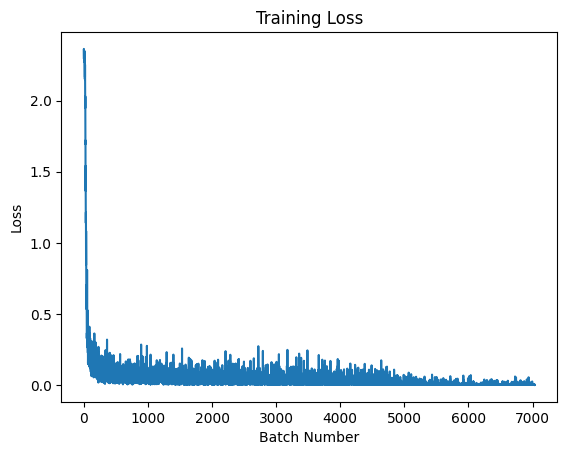

In [ ]:
# Training MNIST on AlexNet
optimizer,criterion,scheduler = CNN_par(alexnet)
train(15, alexnet, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99%)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       1.00      0.99      1.00       982
           5       0.99      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

F1 Score: 0.9945027257999424


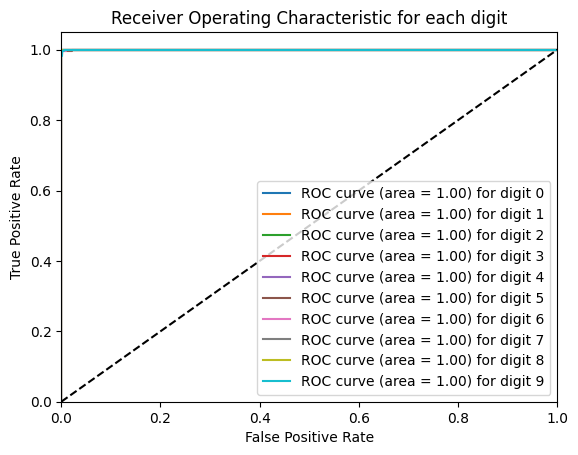

In [ ]:
# Testing MNIST on ALexNet
evaluate(alexnet, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.4294
Epoch 2/20 completed. Loss: 0.2313
Epoch 3/20 completed. Loss: 0.2660
Epoch 4/20 completed. Loss: 0.2198
Epoch 5/20 completed. Loss: 0.1714
Epoch 6/20 completed. Loss: 0.2789
Epoch 7/20 completed. Loss: 0.3088
Epoch 8/20 completed. Loss: 0.2249
Epoch 9/20 completed. Loss: 0.0694
Epoch 10/20 completed. Loss: 0.1432
Epoch 11/20 completed. Loss: 0.2243
Epoch 12/20 completed. Loss: 0.0720
Epoch 13/20 completed. Loss: 0.1397
Epoch 14/20 completed. Loss: 0.0622
Epoch 15/20 completed. Loss: 0.0570
Epoch 16/20 completed. Loss: 0.0990
Epoch 17/20 completed. Loss: 0.1124
Epoch 18/20 completed. Loss: 0.0276
Epoch 19/20 completed. Loss: 0.0152
Epoch 20/20 completed. Loss: 0.0419


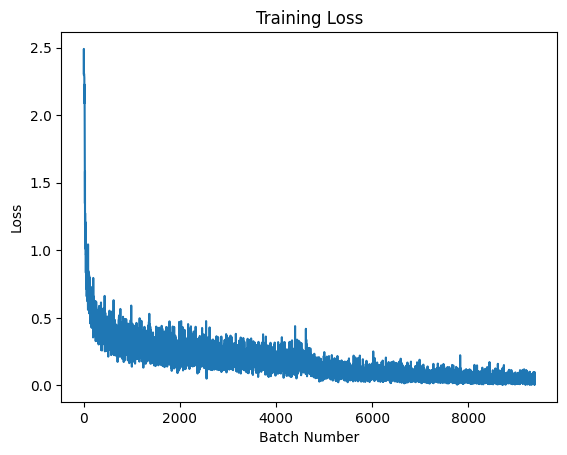

In [ ]:
# Training FMNIST on ALexNet
optimizer,criterion,scheduler = CNN_par(alexnet)
train(20, alexnet, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0027, Accuracy: 9245/10000 (92%)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.87      0.90      0.88      1000
       Dress       0.94      0.93      0.93      1000
        Coat       0.87      0.89      0.88      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.80      0.74      0.77      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

F1 Score: 0.9241334325203099


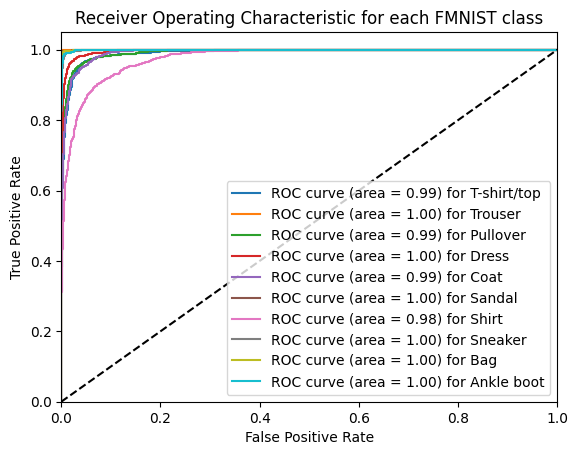

In [ ]:
# Testing FMNIST on AlexNet
evaluate(alexnet, test_loader_fmnist, criterion)

In [ ]:
# Re-defining the AlexNet architecture to train CIFAR-10
class AlexNet_C(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_C, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

alexnet_cif = AlexNet_C().to(device)

Epoch 1/20 completed. Loss: 1.4087
Epoch 2/20 completed. Loss: 1.1307
Epoch 3/20 completed. Loss: 0.9600
Epoch 4/20 completed. Loss: 0.7213
Epoch 5/20 completed. Loss: 0.9461
Epoch 6/20 completed. Loss: 0.6048
Epoch 7/20 completed. Loss: 0.6059
Epoch 8/20 completed. Loss: 0.5023
Epoch 9/20 completed. Loss: 0.6400
Epoch 10/20 completed. Loss: 0.4796
Epoch 11/20 completed. Loss: 0.1465
Epoch 12/20 completed. Loss: 0.2716
Epoch 13/20 completed. Loss: 0.1432
Epoch 14/20 completed. Loss: 0.1194
Epoch 15/20 completed. Loss: 0.1108
Epoch 16/20 completed. Loss: 0.1014
Epoch 17/20 completed. Loss: 0.0839
Epoch 18/20 completed. Loss: 0.1175
Epoch 19/20 completed. Loss: 0.0700
Epoch 20/20 completed. Loss: 0.0886


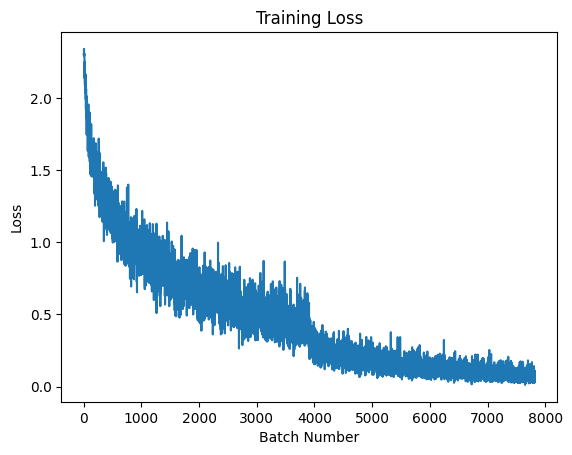

In [ ]:
# Training CIFAR-10 on AlexNet
optimizer,criterion,scheduler = CNN_par(alexnet_cif)
train(20, alexnet_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0083, Accuracy: 7995/10000 (80%)

              precision    recall  f1-score   support

    Airplane       0.80      0.83      0.82      1000
  Automobile       0.92      0.89      0.91      1000
        Bird       0.76      0.70      0.72      1000
         Cat       0.61      0.63      0.62      1000
        Deer       0.77      0.76      0.76      1000
         Dog       0.69      0.71      0.70      1000
        Frog       0.85      0.84      0.85      1000
       Horse       0.85      0.86      0.85      1000
        Ship       0.87      0.90      0.89      1000
       Truck       0.88      0.87      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

F1 Score: 0.7995850840616768


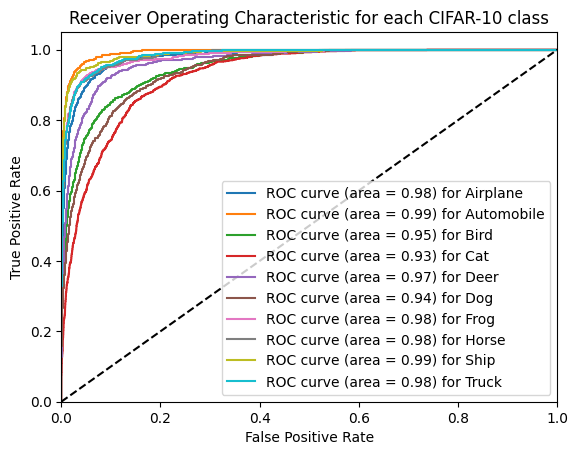

In [ ]:
# Testing CIFAR-10 on AlexNet
evaluate(alexnet_cif, test_loader_cifar10, criterion)

In [ ]:
# Defining GoogLeNet
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192)
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

googlenet = GoogLeNet(num_classes=10).to(device)


Epoch 1/15 completed. Loss: 0.1588
Epoch 2/15 completed. Loss: 0.0251
Epoch 3/15 completed. Loss: 0.1568
Epoch 4/15 completed. Loss: 0.1465
Epoch 5/15 completed. Loss: 0.0387
Epoch 6/15 completed. Loss: 0.0036
Epoch 7/15 completed. Loss: 0.0105
Epoch 8/15 completed. Loss: 0.0045
Epoch 9/15 completed. Loss: 0.0125
Epoch 10/15 completed. Loss: 0.0257
Epoch 11/15 completed. Loss: 0.0002
Epoch 12/15 completed. Loss: 0.0001
Epoch 13/15 completed. Loss: 0.0007
Epoch 14/15 completed. Loss: 0.0004
Epoch 15/15 completed. Loss: 0.0000


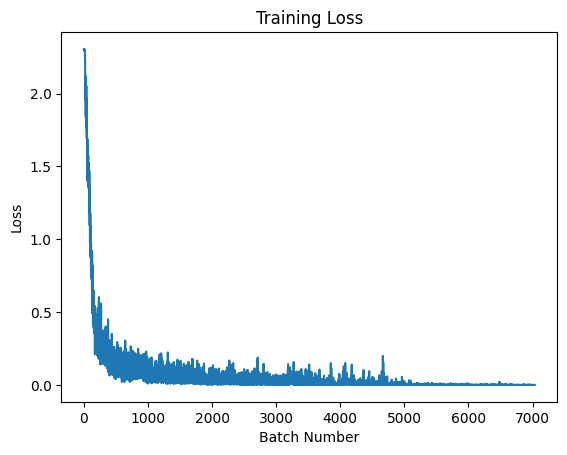

In [ ]:
# Training MNIST on GoogLeNet
optimizer,criterion,scheduler = CNN_par(googlenet,lr=0.0001)
train(15, googlenet, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0004, Accuracy: 9897/10000 (99%)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

F1 Score: 0.9895902322884673


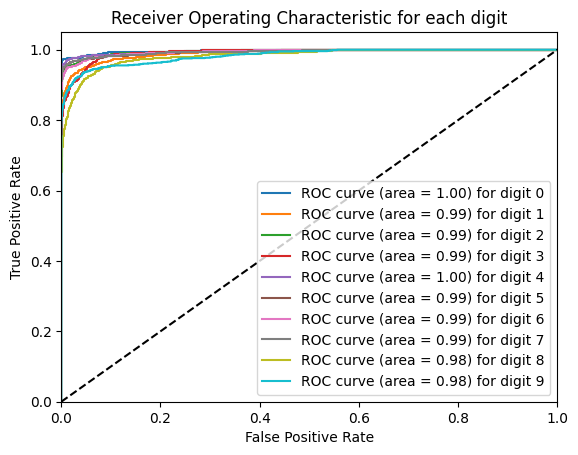

In [ ]:
# Testing MNIST on GoogLNet
evaluate(googlenet, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.3418
Epoch 2/20 completed. Loss: 0.3258
Epoch 3/20 completed. Loss: 0.1818
Epoch 4/20 completed. Loss: 0.1923
Epoch 5/20 completed. Loss: 0.1559
Epoch 6/20 completed. Loss: 0.1807
Epoch 7/20 completed. Loss: 0.1340
Epoch 8/20 completed. Loss: 0.1875
Epoch 9/20 completed. Loss: 0.1225
Epoch 10/20 completed. Loss: 0.0381
Epoch 11/20 completed. Loss: 0.0190
Epoch 12/20 completed. Loss: 0.0216
Epoch 13/20 completed. Loss: 0.0042
Epoch 14/20 completed. Loss: 0.0028
Epoch 15/20 completed. Loss: 0.0040
Epoch 16/20 completed. Loss: 0.0073
Epoch 17/20 completed. Loss: 0.0008
Epoch 18/20 completed. Loss: 0.0001
Epoch 19/20 completed. Loss: 0.0005
Epoch 20/20 completed. Loss: 0.0015


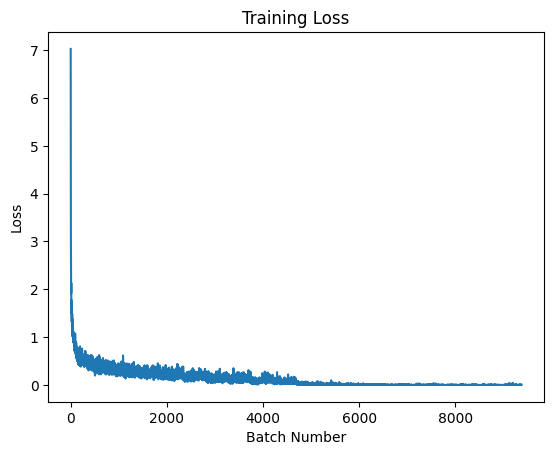

In [ ]:
# Training FMNIST on GoogLeNet
optimizer,criterion,scheduler = CNN_par(googlenet,lr=0.0001)
train(20, googlenet, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0081, Accuracy: 8910/10000 (89%)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.78      0.82      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.81      0.84      0.82      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.81      0.84      0.82      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.72      0.69      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

F1 Score: 0.8907145716061553


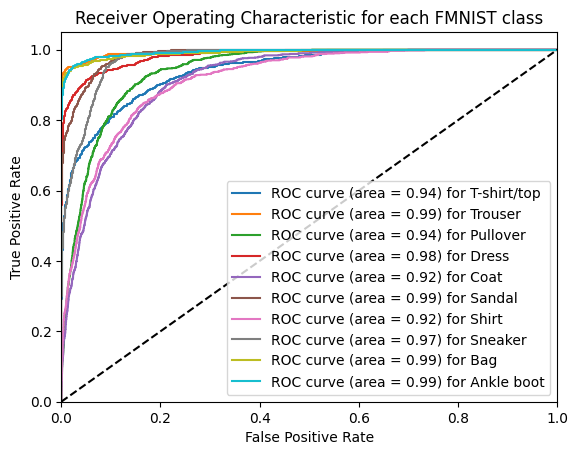

In [ ]:
# Testing FMNIST on GoogLeNet
evaluate(googlenet, test_loader_fmnist, criterion)

In [ ]:
# Refining the GoogLeNet for CIFAR-10
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class GoogLeNet_C(nn.Module):
    def __init__(self):
        super(GoogLeNet_C, self).__init__()
        # CIFAR-10 has 3-channel RGB images, and we start with a 3x3 convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

googlenet_cif = GoogLeNet_C().to(device)


Epoch 1/20 completed. Loss: 1.6430
Epoch 2/20 completed. Loss: 1.3874
Epoch 3/20 completed. Loss: 0.9656
Epoch 4/20 completed. Loss: 1.1401
Epoch 5/20 completed. Loss: 1.0557
Epoch 6/20 completed. Loss: 1.0634
Epoch 7/20 completed. Loss: 0.8566
Epoch 8/20 completed. Loss: 0.7348
Epoch 9/20 completed. Loss: 0.5934
Epoch 10/20 completed. Loss: 0.6761
Epoch 11/20 completed. Loss: 0.2059
Epoch 12/20 completed. Loss: 0.3491
Epoch 13/20 completed. Loss: 0.3942
Epoch 14/20 completed. Loss: 0.3436
Epoch 15/20 completed. Loss: 0.2789
Epoch 16/20 completed. Loss: 0.2332
Epoch 17/20 completed. Loss: 0.1865
Epoch 18/20 completed. Loss: 0.3583
Epoch 19/20 completed. Loss: 0.2121
Epoch 20/20 completed. Loss: 0.2412


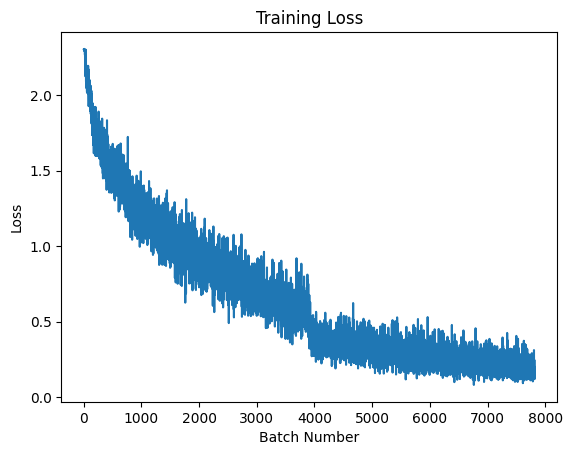

In [ ]:
# Training CIFAR-10 on GoogLeNet
optimizer,criterion,scheduler = CNN_par(googlenet_cif,lr=0.0001)
train(20, googlenet_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0085, Accuracy: 7522/10000 (75%)

              precision    recall  f1-score   support

    Airplane       0.78      0.81      0.79      1000
  Automobile       0.88      0.84      0.86      1000
        Bird       0.72      0.66      0.69      1000
         Cat       0.53      0.58      0.56      1000
        Deer       0.73      0.70      0.72      1000
         Dog       0.65      0.64      0.64      1000
        Frog       0.80      0.81      0.80      1000
       Horse       0.76      0.81      0.79      1000
        Ship       0.88      0.82      0.85      1000
       Truck       0.80      0.86      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

F1 Score: 0.7528037624764646


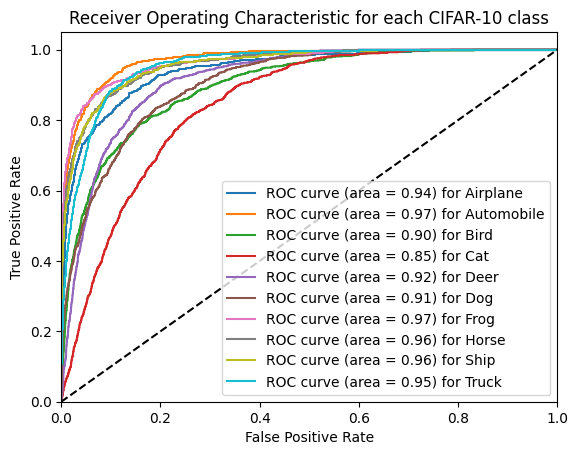

In [ ]:
# Testing CIFAR-10 on GoogLeNet
evaluate(googlenet_cif, test_loader_cifar10, criterion)

In [ ]:
#Defining VGGNet
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


vggnet = VGGNet(num_classes=10).to(device)


Epoch 1/15 completed. Loss: 0.0041
Epoch 2/15 completed. Loss: 0.0433
Epoch 3/15 completed. Loss: 0.0004
Epoch 4/15 completed. Loss: 0.0562
Epoch 5/15 completed. Loss: 0.0055
Epoch 6/15 completed. Loss: 0.0374
Epoch 7/15 completed. Loss: 0.0187
Epoch 8/15 completed. Loss: 0.0278
Epoch 9/15 completed. Loss: 0.0195
Epoch 10/15 completed. Loss: 0.0325
Epoch 11/15 completed. Loss: 0.0029
Epoch 12/15 completed. Loss: 0.0002
Epoch 13/15 completed. Loss: 0.0000
Epoch 14/15 completed. Loss: 0.0000
Epoch 15/15 completed. Loss: 0.0000


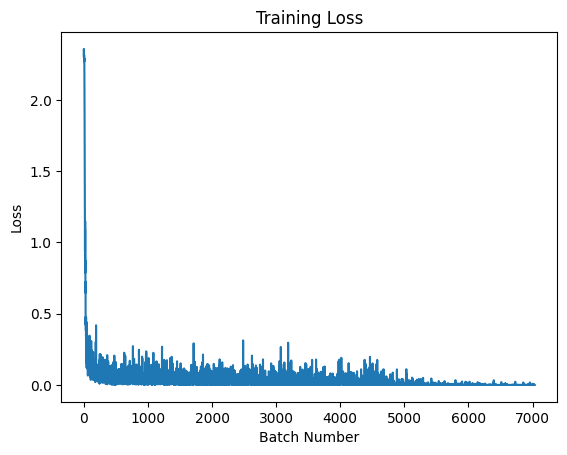

In [ ]:
# Training MNIST on VGGNet
optimizer,criterion,scheduler = CNN_par(vggnet)
train(15, vggnet, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0003, Accuracy: 9934/10000 (99%)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

F1 Score: 0.993334489301106


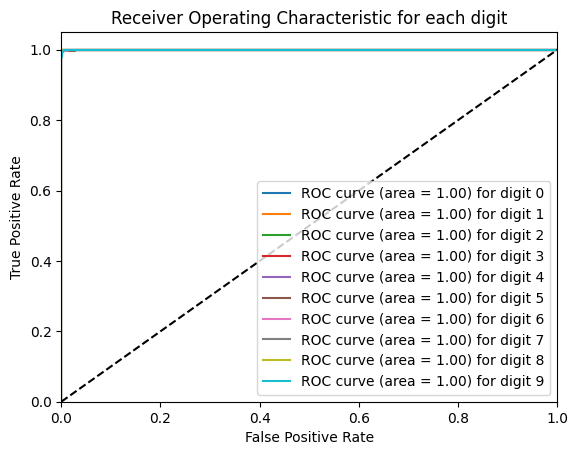

In [ ]:
# Testing MNIST on VGGNet
evaluate(vggnet, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.3856
Epoch 2/20 completed. Loss: 0.2475
Epoch 3/20 completed. Loss: 0.1409
Epoch 4/20 completed. Loss: 0.3041
Epoch 5/20 completed. Loss: 0.1266
Epoch 6/20 completed. Loss: 0.1587
Epoch 7/20 completed. Loss: 0.1663
Epoch 8/20 completed. Loss: 0.1169
Epoch 9/20 completed. Loss: 0.0943
Epoch 10/20 completed. Loss: 0.0363
Epoch 11/20 completed. Loss: 0.0238
Epoch 12/20 completed. Loss: 0.0359
Epoch 13/20 completed. Loss: 0.0023
Epoch 14/20 completed. Loss: 0.0002
Epoch 15/20 completed. Loss: 0.0007
Epoch 16/20 completed. Loss: 0.0083
Epoch 17/20 completed. Loss: 0.0018
Epoch 18/20 completed. Loss: 0.0006
Epoch 19/20 completed. Loss: 0.0001
Epoch 20/20 completed. Loss: 0.0003


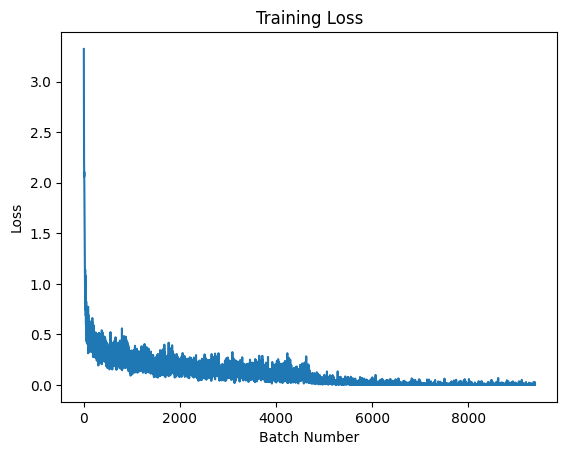

In [ ]:
# Training FMNIST on VGGNet
optimizer,criterion,scheduler = CNN_par(vggnet)
train(20, vggnet, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0065, Accuracy: 9165/10000 (92%)

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.83      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.88      0.87      1000
       Dress       0.93      0.91      0.92      1000
        Coat       0.87      0.89      0.88      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.74      0.78      0.76      1000
     Sneaker       0.97      0.96      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

F1 Score: 0.9167934906692696


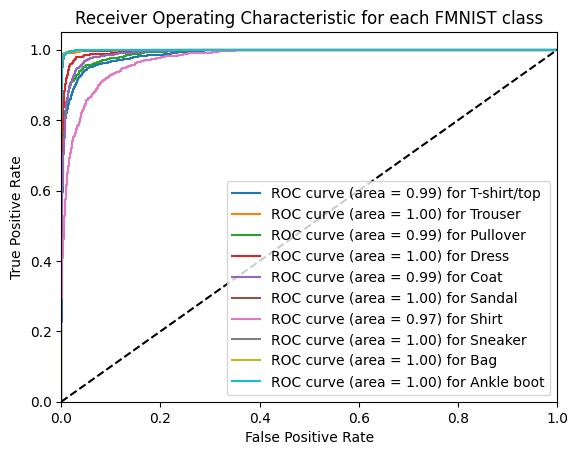

In [ ]:
# Testing FMNIST on VGGNet
evaluate(vggnet, test_loader_fmnist, criterion)

In [ ]:
# Refining the neural network for CIFAR-10
class VGGNet_C(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet_C, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate model
vggnet_cif = VGGNet_C(num_classes=10).to(device)

Epoch 1/20 completed. Loss: 1.5944
Epoch 2/20 completed. Loss: 1.2967
Epoch 3/20 completed. Loss: 0.9629
Epoch 4/20 completed. Loss: 0.8774
Epoch 5/20 completed. Loss: 0.8005
Epoch 6/20 completed. Loss: 0.8110
Epoch 7/20 completed. Loss: 0.5749
Epoch 8/20 completed. Loss: 0.5685
Epoch 9/20 completed. Loss: 0.6128
Epoch 10/20 completed. Loss: 0.5680
Epoch 11/20 completed. Loss: 0.1656
Epoch 12/20 completed. Loss: 0.2087
Epoch 13/20 completed. Loss: 0.1569
Epoch 14/20 completed. Loss: 0.1206
Epoch 15/20 completed. Loss: 0.1051
Epoch 16/20 completed. Loss: 0.0385
Epoch 17/20 completed. Loss: 0.0506
Epoch 18/20 completed. Loss: 0.0177
Epoch 19/20 completed. Loss: 0.0075
Epoch 20/20 completed. Loss: 0.0027


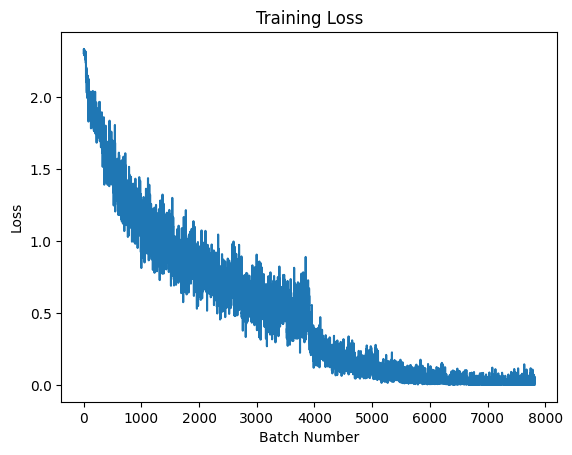

In [ ]:
# Training CIFAR-10 on VGGNet
optimizer,criterion,scheduler = CNN_par(vggnet_cif)
train(20, vggnet_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0202, Accuracy: 7280/10000 (73%)

              precision    recall  f1-score   support

    Airplane       0.73      0.78      0.75      1000
  Automobile       0.85      0.83      0.84      1000
        Bird       0.63      0.62      0.62      1000
         Cat       0.51      0.54      0.53      1000
        Deer       0.71      0.68      0.70      1000
         Dog       0.65      0.59      0.62      1000
        Frog       0.78      0.81      0.79      1000
       Horse       0.78      0.77      0.78      1000
        Ship       0.86      0.82      0.84      1000
       Truck       0.79      0.83      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

F1 Score: 0.7280919780660424


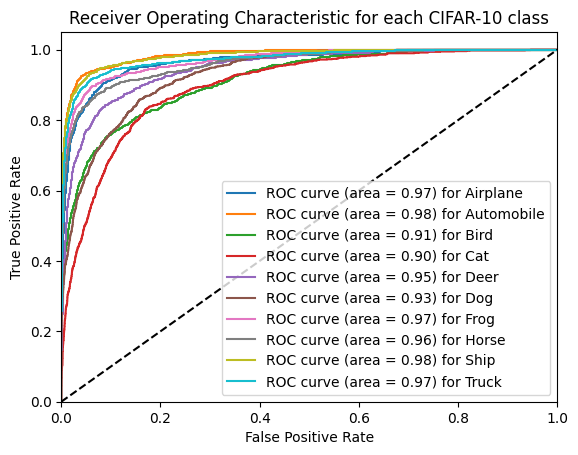

In [ ]:
# Testing CIFAR-10 on VGGNet
evaluate(vggnet_cif, test_loader_cifar10, criterion)

In [ ]:
# Defining ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

resnet = ResNet18(num_classes=10).to(device)

Epoch 1/15 completed. Loss: 0.0558
Epoch 2/15 completed. Loss: 0.0239
Epoch 3/15 completed. Loss: 0.0039
Epoch 4/15 completed. Loss: 0.0013
Epoch 5/15 completed. Loss: 0.0345
Epoch 6/15 completed. Loss: 0.0012
Epoch 7/15 completed. Loss: 0.0140
Epoch 8/15 completed. Loss: 0.0111
Epoch 9/15 completed. Loss: 0.0043
Epoch 10/15 completed. Loss: 0.0106
Epoch 11/15 completed. Loss: 0.0006
Epoch 12/15 completed. Loss: 0.0002
Epoch 13/15 completed. Loss: 0.0002
Epoch 14/15 completed. Loss: 0.0010
Epoch 15/15 completed. Loss: 0.0002


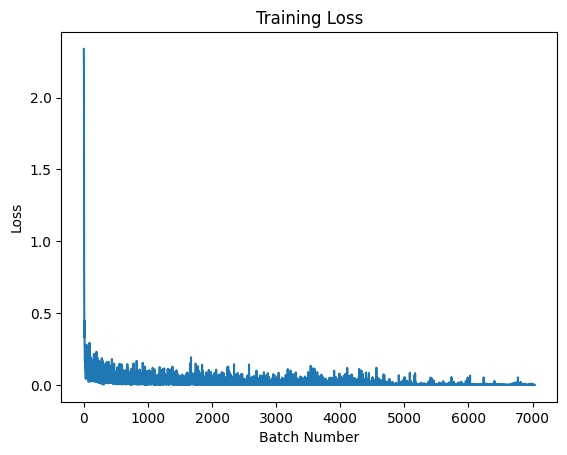

In [ ]:
# Training MNIST on ResNet
optimizer,criterion,scheduler = CNN_par(resnet)
train(15, resnet, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0001, Accuracy: 9963/10000 (100%)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      1.00       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      1.00      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

F1 Score: 0.9962813515899251


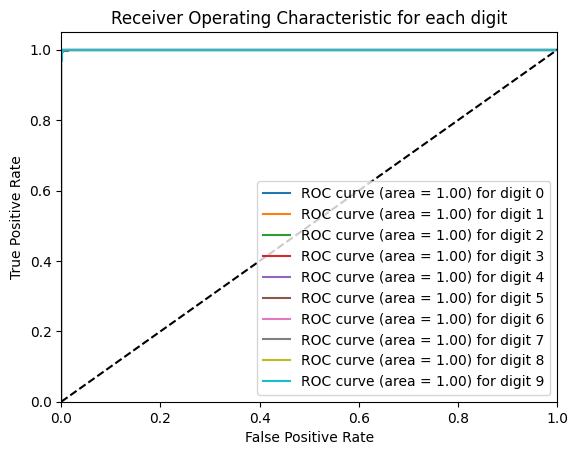

In [ ]:
# Testing MNIST on ResNet
evaluate(resnet, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.2632
Epoch 2/20 completed. Loss: 0.2345
Epoch 3/20 completed. Loss: 0.1836
Epoch 4/20 completed. Loss: 0.0628
Epoch 5/20 completed. Loss: 0.1173
Epoch 6/20 completed. Loss: 0.0334
Epoch 7/20 completed. Loss: 0.1233
Epoch 8/20 completed. Loss: 0.0544
Epoch 9/20 completed. Loss: 0.0683
Epoch 10/20 completed. Loss: 0.0447
Epoch 11/20 completed. Loss: 0.0011
Epoch 12/20 completed. Loss: 0.0017
Epoch 13/20 completed. Loss: 0.0006
Epoch 14/20 completed. Loss: 0.0013
Epoch 15/20 completed. Loss: 0.0013
Epoch 16/20 completed. Loss: 0.0015
Epoch 17/20 completed. Loss: 0.0001
Epoch 18/20 completed. Loss: 0.0002
Epoch 19/20 completed. Loss: 0.0002
Epoch 20/20 completed. Loss: 0.0003


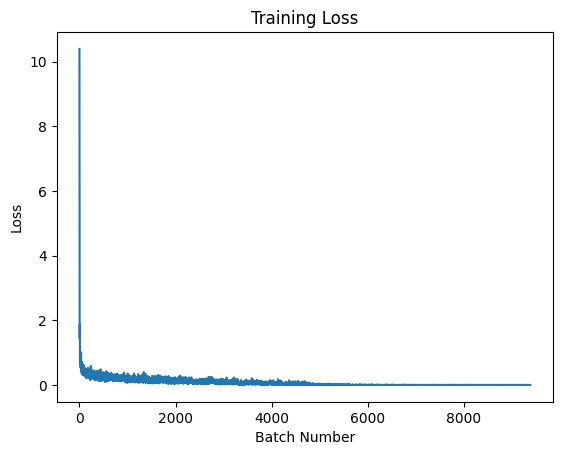

In [ ]:
# Training FMNIST on ResNet
optimizer,criterion,scheduler = CNN_par(resnet)
train(20, resnet, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0030, Accuracy: 9376/10000 (94%)

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.89      0.89      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.91      0.91      0.91      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.89      0.92      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.84      0.80      0.82      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

F1 Score: 0.9374343642310109


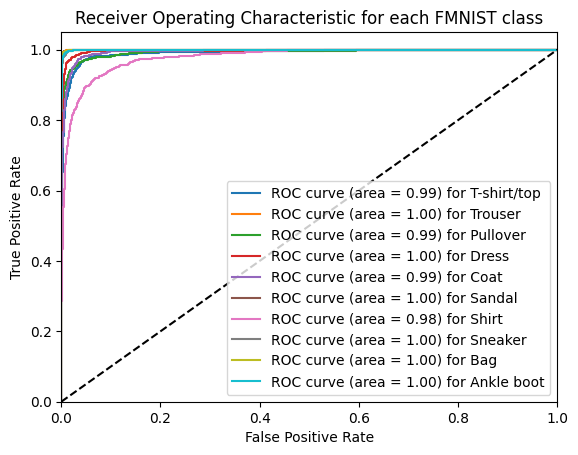

In [ ]:
# Testing FMNIST on ResNet
evaluate(resnet, test_loader_fmnist, criterion)

In [ ]:
# Refining the neural newtwork fro CIFAR-10
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet_C(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_C, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18_C(num_classes=10):
    return ResNet_C(BasicBlock, [2, 2, 2, 2], num_classes)

resnet_cif = ResNet18_C(num_classes=10).to(device)

Epoch 1/20 completed. Loss: 0.8976
Epoch 2/20 completed. Loss: 0.7125
Epoch 3/20 completed. Loss: 0.8541
Epoch 4/20 completed. Loss: 0.3927
Epoch 5/20 completed. Loss: 0.2775
Epoch 6/20 completed. Loss: 0.2564
Epoch 7/20 completed. Loss: 0.2250
Epoch 8/20 completed. Loss: 0.1710
Epoch 9/20 completed. Loss: 0.1291
Epoch 10/20 completed. Loss: 0.0789
Epoch 11/20 completed. Loss: 0.0233
Epoch 12/20 completed. Loss: 0.0312
Epoch 13/20 completed. Loss: 0.0026
Epoch 14/20 completed. Loss: 0.0060
Epoch 15/20 completed. Loss: 0.0015
Epoch 16/20 completed. Loss: 0.0036
Epoch 17/20 completed. Loss: 0.0015
Epoch 18/20 completed. Loss: 0.0008
Epoch 19/20 completed. Loss: 0.0015
Epoch 20/20 completed. Loss: 0.0006


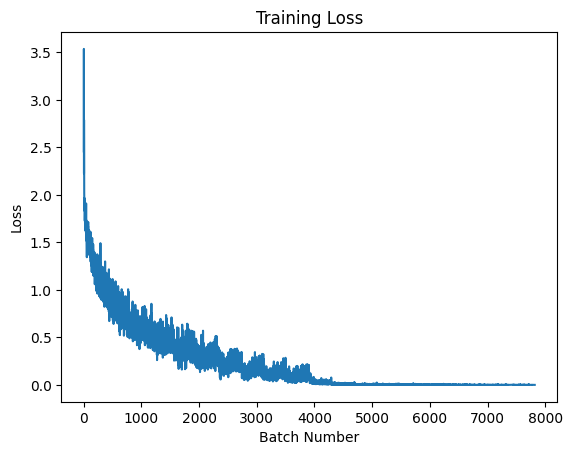

In [ ]:
# Training CIFAR-10 on ResNet
optimizer,criterion,scheduler = CNN_par(resnet_cif)
train(20, resnet_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0050, Accuracy: 8686/10000 (87%)

              precision    recall  f1-score   support

    Airplane       0.86      0.90      0.88      1000
  Automobile       0.94      0.94      0.94      1000
        Bird       0.83      0.80      0.81      1000
         Cat       0.76      0.75      0.75      1000
        Deer       0.83      0.86      0.85      1000
         Dog       0.83      0.80      0.81      1000
        Frog       0.88      0.90      0.89      1000
       Horse       0.91      0.90      0.90      1000
        Ship       0.92      0.93      0.92      1000
       Truck       0.93      0.92      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

F1 Score: 0.8682456868672771


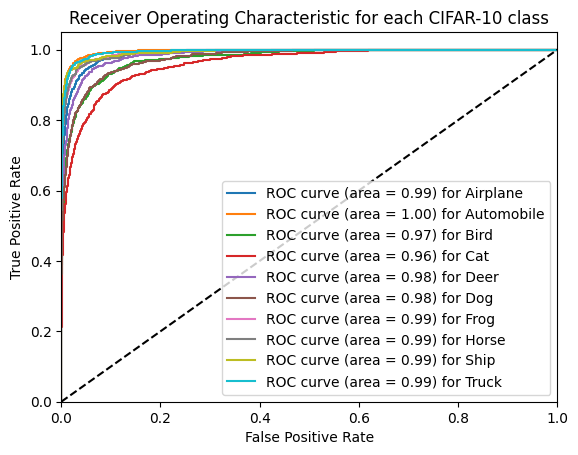

In [ ]:
# Testing CIFAR-10 on ResNet
evaluate(resnet_cif, test_loader_cifar10, criterion)

In [ ]:
# Defining Xception
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Xception(nn.Module):
    def __init__(self, num_classes=10):
        super(Xception, self).__init__()
        self.entry_flow = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.middle_flow = nn.Sequential(
            SeparableConv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SeparableConv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SeparableConv2d(256, 728, kernel_size=3, padding=1),
            nn.BatchNorm2d(728),
            nn.ReLU(),
        )

        self.exit_flow = nn.Sequential(
            SeparableConv2d(728, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

xception = Xception(num_classes=10).to(device)

Epoch 1/15 completed. Loss: 0.0751
Epoch 2/15 completed. Loss: 0.0958
Epoch 3/15 completed. Loss: 0.0132
Epoch 4/15 completed. Loss: 0.0160
Epoch 5/15 completed. Loss: 0.0455
Epoch 6/15 completed. Loss: 0.0413
Epoch 7/15 completed. Loss: 0.0276
Epoch 8/15 completed. Loss: 0.0039
Epoch 9/15 completed. Loss: 0.0009
Epoch 10/15 completed. Loss: 0.0074
Epoch 11/15 completed. Loss: 0.0006
Epoch 12/15 completed. Loss: 0.0013
Epoch 13/15 completed. Loss: 0.0004
Epoch 14/15 completed. Loss: 0.0005
Epoch 15/15 completed. Loss: 0.0002


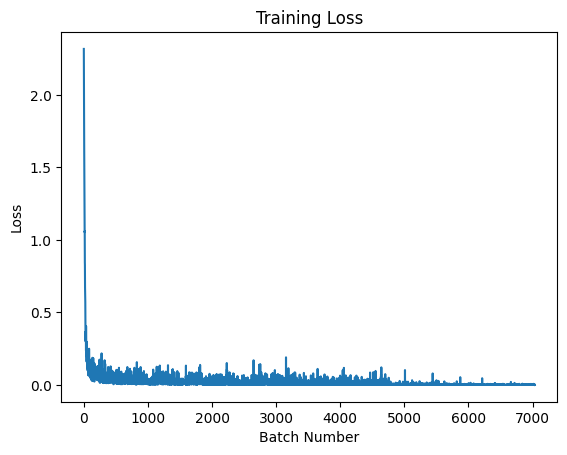

In [ ]:
# Training MNIST on Xception
optimizer,criterion,scheduler = CNN_par(xception)
train(15, xception, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0001, Accuracy: 9961/10000 (100%)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      0.99      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

F1 Score: 0.9960982898507998


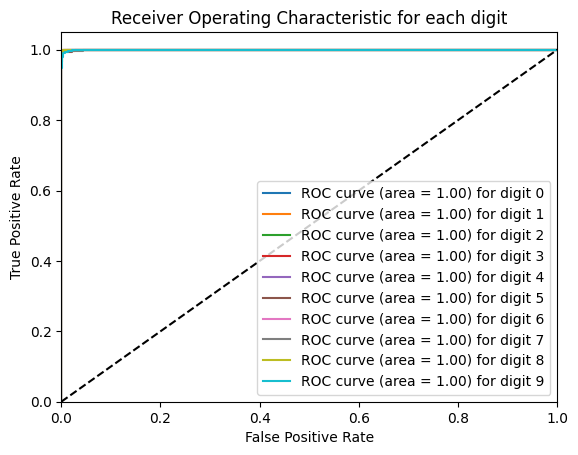

In [ ]:
# Testing MNIST on Xception
evaluate(xception, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.2085
Epoch 2/20 completed. Loss: 0.2512
Epoch 3/20 completed. Loss: 0.2321
Epoch 4/20 completed. Loss: 0.2540
Epoch 5/20 completed. Loss: 0.2192
Epoch 6/20 completed. Loss: 0.1973
Epoch 7/20 completed. Loss: 0.1872
Epoch 8/20 completed. Loss: 0.0794
Epoch 9/20 completed. Loss: 0.1064
Epoch 10/20 completed. Loss: 0.1270
Epoch 11/20 completed. Loss: 0.0508
Epoch 12/20 completed. Loss: 0.0160
Epoch 13/20 completed. Loss: 0.0183
Epoch 14/20 completed. Loss: 0.0220
Epoch 15/20 completed. Loss: 0.0060
Epoch 16/20 completed. Loss: 0.0146
Epoch 17/20 completed. Loss: 0.0061
Epoch 18/20 completed. Loss: 0.0109
Epoch 19/20 completed. Loss: 0.0051
Epoch 20/20 completed. Loss: 0.0027


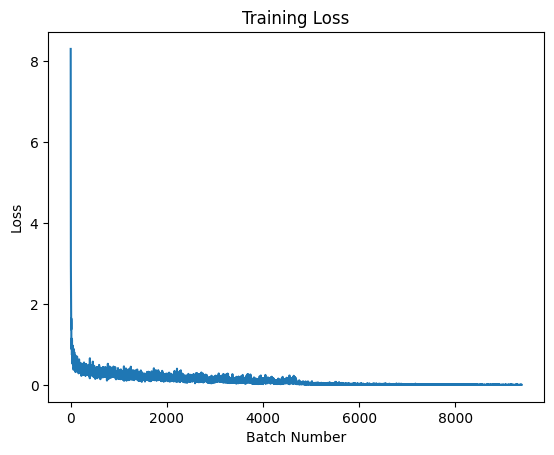

In [ ]:
# Training FMNIST on Xception
optimizer,criterion,scheduler = CNN_par(xception)
train(20, xception, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0028, Accuracy: 9220/10000 (92%)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.87      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.89      0.88      1000
       Dress       0.90      0.95      0.92      1000
        Coat       0.90      0.86      0.88      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.79      0.75      0.77      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.99      0.97      0.98      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

F1 Score: 0.9216162447286911


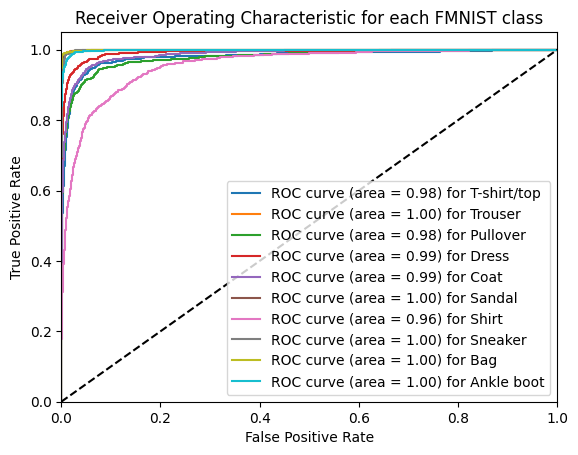

In [ ]:
# Testing FMNIST on Xception
evaluate(xception, test_loader_fmnist, criterion)

In [ ]:
# Refining the neural network for CIFAR-10
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Xception_C(nn.Module):
    def __init__(self, num_classes=10):
        super(Xception_C, self).__init__()
        self.entry_flow = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.middle_flow = nn.Sequential(
            SeparableConv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SeparableConv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SeparableConv2d(256, 728, kernel_size=3, padding=1),
            nn.BatchNorm2d(728),
            nn.ReLU(),
        )

        self.exit_flow = nn.Sequential(
            SeparableConv2d(728, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

xception_cif = Xception_C(num_classes=10).to(device)

Epoch 1/20 completed. Loss: 1.1314
Epoch 2/20 completed. Loss: 0.7148
Epoch 3/20 completed. Loss: 0.7866
Epoch 4/20 completed. Loss: 0.4416
Epoch 5/20 completed. Loss: 0.5267
Epoch 6/20 completed. Loss: 0.3995
Epoch 7/20 completed. Loss: 0.4777
Epoch 8/20 completed. Loss: 0.3204
Epoch 9/20 completed. Loss: 0.3488
Epoch 10/20 completed. Loss: 0.2931
Epoch 11/20 completed. Loss: 0.1180
Epoch 12/20 completed. Loss: 0.0738
Epoch 13/20 completed. Loss: 0.0517
Epoch 14/20 completed. Loss: 0.0464
Epoch 15/20 completed. Loss: 0.0671
Epoch 16/20 completed. Loss: 0.0589
Epoch 17/20 completed. Loss: 0.0551
Epoch 18/20 completed. Loss: 0.0263
Epoch 19/20 completed. Loss: 0.0214
Epoch 20/20 completed. Loss: 0.0203


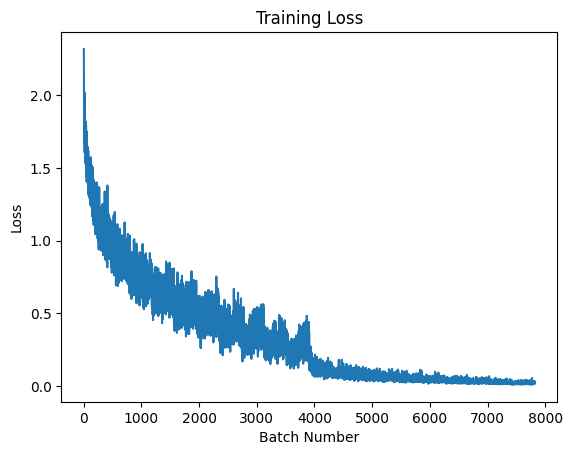

In [ ]:
# Training CIFAR-10 on Xception
optimizer,criterion,scheduler = CNN_par(xception_cif)
train(20, xception_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0056, Accuracy: 8112/10000 (81%)

              precision    recall  f1-score   support

    Airplane       0.81      0.86      0.84      1000
  Automobile       0.88      0.92      0.90      1000
        Bird       0.74      0.75      0.74      1000
         Cat       0.72      0.55      0.62      1000
        Deer       0.79      0.79      0.79      1000
         Dog       0.70      0.75      0.73      1000
        Frog       0.80      0.88      0.84      1000
       Horse       0.87      0.82      0.85      1000
        Ship       0.90      0.91      0.91      1000
       Truck       0.87      0.87      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

F1 Score: 0.8089333170955746


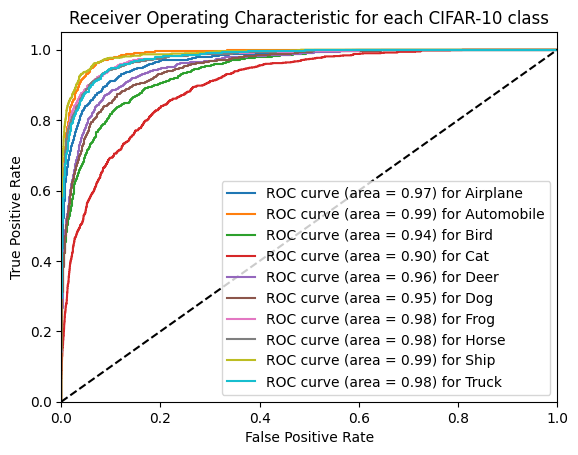

In [ ]:
# Testing CIFAR-10 on Xception
evaluate(xception_cif, test_loader_cifar10, criterion)

In [ ]:
# Defining SENet
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SENet(nn.Module):
    def __init__(self, num_classes=10):
        super(SENet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.se1 = SEBlock(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.se2 = SEBlock(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.se3 = SEBlock(256)

        self.fc = nn.Linear(256 * 28 * 28, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

senet = SENet(num_classes=10).to(device)

Epoch 1/15 completed. Loss: 0.1608
Epoch 2/15 completed. Loss: 0.0269
Epoch 3/15 completed. Loss: 0.0165
Epoch 4/15 completed. Loss: 0.0069
Epoch 5/15 completed. Loss: 0.0034
Epoch 6/15 completed. Loss: 0.0681
Epoch 7/15 completed. Loss: 0.0161
Epoch 8/15 completed. Loss: 0.0120
Epoch 9/15 completed. Loss: 0.0143
Epoch 10/15 completed. Loss: 0.0035
Epoch 11/15 completed. Loss: 0.0005
Epoch 12/15 completed. Loss: 0.0001
Epoch 13/15 completed. Loss: 0.0004
Epoch 14/15 completed. Loss: 0.0007
Epoch 15/15 completed. Loss: 0.0000


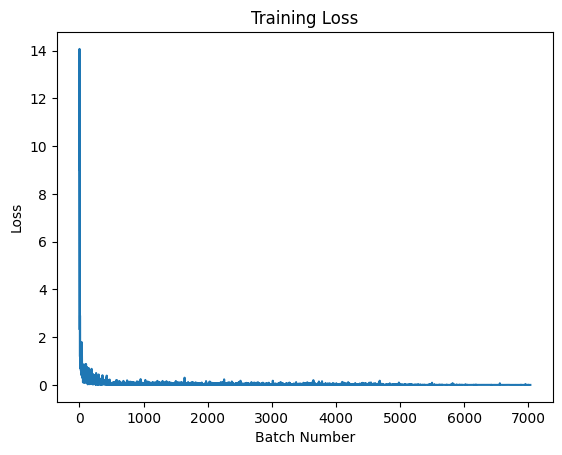

In [ ]:
# Training MNIST on SENet
optimizer,criterion,scheduler = CNN_par(senet)
train(15, senet, train_loader_mnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0003, Accuracy: 9907/10000 (99%)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

F1 Score: 0.9906011396579318


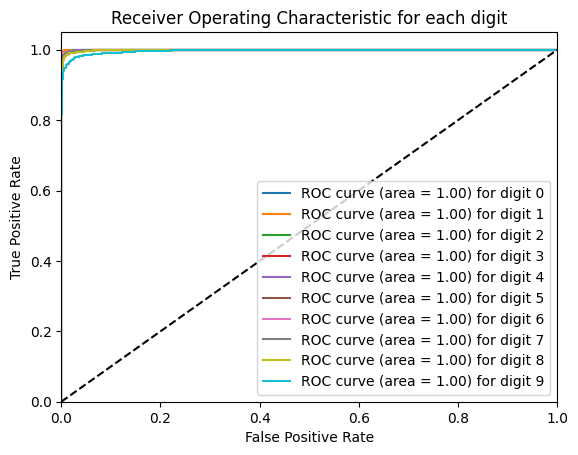

In [ ]:
# Testing MNIST on SENet
evaluate(senet, test_loader_mnist, criterion)

Epoch 1/20 completed. Loss: 0.3562
Epoch 2/20 completed. Loss: 0.2448
Epoch 3/20 completed. Loss: 0.2697
Epoch 4/20 completed. Loss: 0.1090
Epoch 5/20 completed. Loss: 0.0572
Epoch 6/20 completed. Loss: 0.1670
Epoch 7/20 completed. Loss: 0.1074
Epoch 8/20 completed. Loss: 0.0171
Epoch 9/20 completed. Loss: 0.0399
Epoch 10/20 completed. Loss: 0.0403
Epoch 11/20 completed. Loss: 0.0071
Epoch 12/20 completed. Loss: 0.0026
Epoch 13/20 completed. Loss: 0.0017
Epoch 14/20 completed. Loss: 0.0038
Epoch 15/20 completed. Loss: 0.0074
Epoch 16/20 completed. Loss: 0.0038
Epoch 17/20 completed. Loss: 0.0234
Epoch 18/20 completed. Loss: 0.0019
Epoch 19/20 completed. Loss: 0.0005
Epoch 20/20 completed. Loss: 0.0003


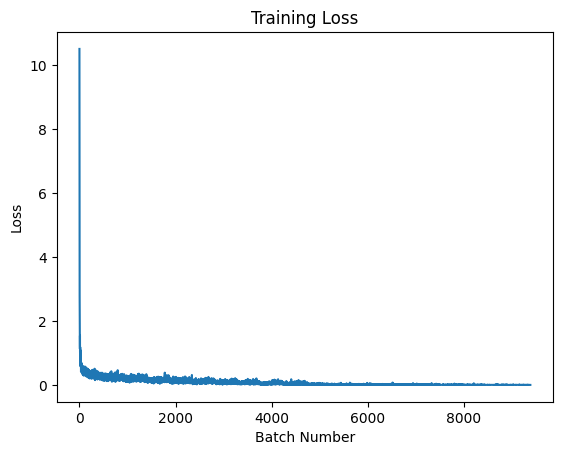

In [ ]:
# Training FMNIST on SENet
optimizer,criterion,scheduler = CNN_par(senet)
train(20, senet, train_loader_fmnist, optimizer, criterion, scheduler)


Test set: Average loss: 0.0041, Accuracy: 9257/10000 (93%)

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.88      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.89      0.89      0.89      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.87      0.89      0.88      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.79      0.78      0.79      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

F1 Score: 0.9256882223645734


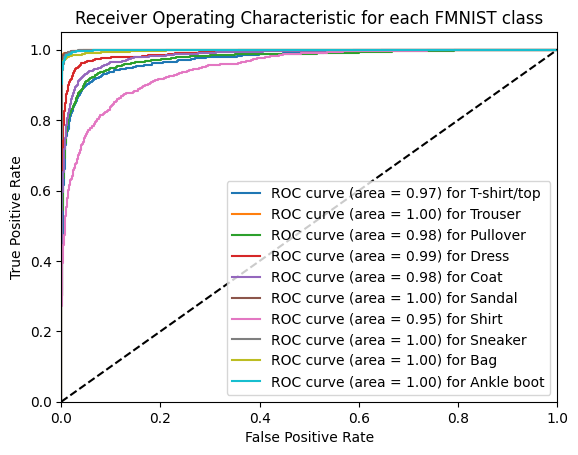

In [ ]:
# Testing FMNIST on SENet
evaluate(senet, test_loader_fmnist, criterion)

In [ ]:
# Refining the neural network for CIFAR-10
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SENet_C(nn.Module):
    def __init__(self, num_classes=10):
        super(SENet_C, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.se1 = SEBlock(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.se2 = SEBlock(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.se3 = SEBlock(256)

        self.fc = nn.Linear(256 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

senet_cif = SENet_C(num_classes=10).to(device)

Epoch 1/20 completed. Loss: 1.3637
Epoch 2/20 completed. Loss: 0.7335
Epoch 3/20 completed. Loss: 0.6285
Epoch 4/20 completed. Loss: 0.5836
Epoch 5/20 completed. Loss: 1.0150
Epoch 6/20 completed. Loss: 0.6444
Epoch 7/20 completed. Loss: 0.3994
Epoch 8/20 completed. Loss: 0.3458
Epoch 9/20 completed. Loss: 0.2620
Epoch 10/20 completed. Loss: 0.3958
Epoch 11/20 completed. Loss: 0.0301
Epoch 12/20 completed. Loss: 0.0047
Epoch 13/20 completed. Loss: 0.0049
Epoch 14/20 completed. Loss: 0.0048
Epoch 15/20 completed. Loss: 0.0063
Epoch 16/20 completed. Loss: 0.0028
Epoch 17/20 completed. Loss: 0.0053
Epoch 18/20 completed. Loss: 0.0023
Epoch 19/20 completed. Loss: 0.0056
Epoch 20/20 completed. Loss: 0.0012


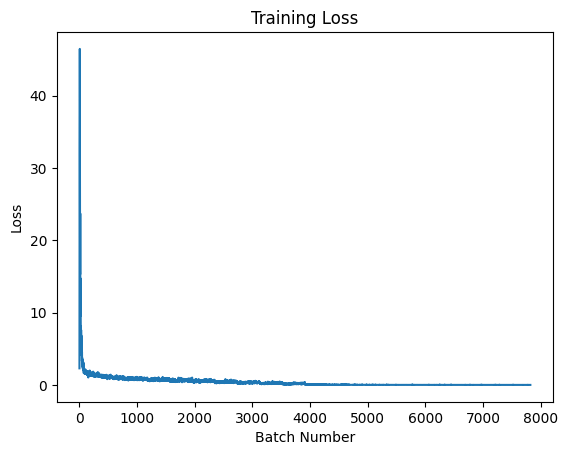

In [ ]:
# Training CIFAR-10 on SENet
optimizer,criterion,scheduler = CNN_par(senet_cif)
train(20, senet_cif, train_loader_cifar10, optimizer, criterion, scheduler)


Test set: Average loss: 0.0138, Accuracy: 7374/10000 (74%)

              precision    recall  f1-score   support

    Airplane       0.72      0.77      0.75      1000
  Automobile       0.86      0.84      0.85      1000
        Bird       0.65      0.64      0.65      1000
         Cat       0.55      0.56      0.55      1000
        Deer       0.71      0.68      0.70      1000
         Dog       0.65      0.65      0.65      1000
        Frog       0.80      0.79      0.80      1000
       Horse       0.77      0.78      0.78      1000
        Ship       0.85      0.83      0.84      1000
       Truck       0.81      0.83      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

F1 Score: 0.7376191177682094


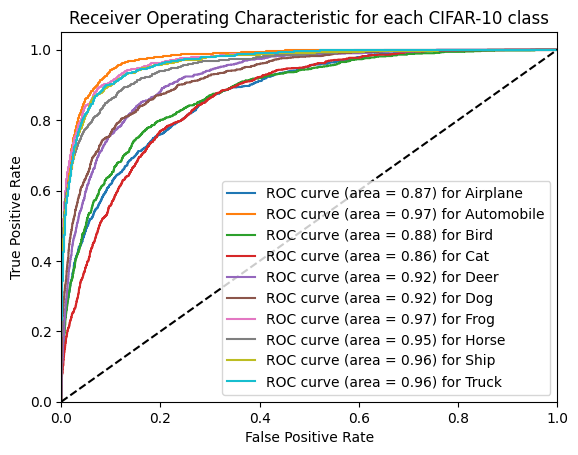

In [ ]:
# Testing CIFAR-10 on SENet
evaluate(senet_cif, test_loader_cifar10, criterion)